# AGN Spectra and emission lines
Before you attempt this notebook, make sure you have watched Clare's science lecture from Week 7 - this will all make more sense if you have. Clare is an expert in the science below, so her explanations will make _far_ more sense than mine below.

Righto, our fearless leader Clare has gifted me some of her reduced spectra data that she took using the Gemini-south telescope (an 8.1m optical/infrared telescope with adaptive optics - more info [here](http://www.gemini.edu/observing/telescopes-and-sites)). This data includes emission from an Active Galactic Nuclei (AGN), an extremely energetic object, consisting of dust and gas spiralling down onto a black hole. They emit radiation at many wavelengths, spanning from radio up to gamma. The most accepted picture of a 'general' AGN is something like this from [Urry & Padovani 1995](https://ui.adsabs.harvard.edu/abs/1995PASP..107..803U/abstract) (this paper has 3379 citations, wow!):

<img src="A-picture-of-the-most-accepted-active-galactic-nuclei-model-Credit-CM-Urry-P-768x848.png" width="400">

where different regions of the AGN have different emission profiles. By observing AGN at different wavelengths, we can try and build up a picture of the structures that make up an AGN, to better understand them and the extreme physics that they probe. 

In the data Clare has sent us, we can look at the 'broadline emission' region, where it's thought fast moving clouds of gas are emitting optical and ultraviolet radiation. Because they are moving, this emission is doppler-shifted, so the radiation that has been emitted at a specific wavelength is 'broadened' over a range of wavelengths, as sometimes it's travelling towards us, sometimes travelling away, as it circles the black hole. By fitting these emission peaks, we can tease out what makes up the broadline emission region and how fast it is moving (amongst other things - see Clare's leture).

We're going to call back to plenty of methods we have learnt earlier in the course, including `astropy.io.fits`, `astropy.wcs.WCS` and `lmfit`. We'll also learn a couple of new things. Strap in kids!

## Reading in the data
We're back to good old `.fits` file. This FITS file contains 2D images of an AGN taken overall multiple frequencies, and so is 3D data (often called a 'spectral cube'). In a previous notebook, we trimmed a 4D FITS file down to 2D to plot. This time, we _don't_ want to throw away the frequency information. You can download this file here: https://drive.google.com/file/d/1aRCeolfJj1Ny7qsiivc0gYtfAO5rXr2v/view?usp=sharing . First up, let's look inside the FITS and see what we have:

In [9]:
from astropy.io import fits

with fits.open('1009_629_2006A_individual_cubes_3D.fits') as hdu:
    hdu.info()
    

Filename: 1009_629_2006A_individual_cubes_3D.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     214   ()      
  1  SCI           1 ImageHDU        68   (39, 50, 6252)   float32   


Ok, so we can see that first hdu (PRIMARY) doesn't actually contain any data, so our data lives in the second entry, so grab the information from that one:

In [10]:
#ou can download this file here: https://drive.google.com/file/d/1aRCeolfJj1Ny7qsiivc0gYtfAO5rXr2v/view?usp=sharing
with fits.open('1009_629_2006A_individual_cubes_3D.fits') as hdu:
    ##Get the data from the 2nd hdu entry
    data = hdu[1].data
    header = hdu[1].header
    ##We'll grab this header too, might need it later
    header_primary = hdu[0].header
    
print(data.shape)

(6252, 50, 39)


Again, note that the order of axes in `data.shape` are opposite to that in `hdu.info()`. This will become important later on when considering coordinate values. First off, let's try and read the `header` information to understand what data we are looking at.

> I will note three things here:
  1. The first thing I did with this data was to open it up using ds9 (see [here](https://sites.google.com/cfa.harvard.edu/saoimageds9)) which allowed me to quickly look inside the data cube. This helped me understand what we can do the the cube using `python`. So install it and use it on your FITS files. It will save you pain, trust me.
  2. This data cube was created using a package called IRAF (see [here](https://iraf-community.github.io/)), so there are probably well-defined ways to read this data. IRAF was used to process the raw data out of the telescope and remove some of the known instrumental effects (and some other things I don't understand). Every package seems to read/write FITS files slightly differently however, so I think it's worth exposing you to the contents of the `header` to give you a working understanding, so you can tackle bespoke FITS files in the future.
  3. As I've said before, when I look at the header of a FITS file, I use `fv` (see [here])(https://heasarc.gsfc.nasa.gov/docs/software/ftools/fv/), which interactively let's me investigate. It's from NASA so it's got to be good, right?
  
Right, let's investigate the contents of the header:

In [11]:
##This feels weird to do, but as a notebook is interactive, and
##due to the way the Header class is constructued, just typing in
##'header' will print out everything in the header
header

XTENSION= 'IMAGE   '           / Image extension                                
BITPIX  =                  -32 / array data type                                
NAXIS   =                    3 / number of array dimensions                     
NAXIS1  =                   39                                                  
NAXIS2  =                   50                                                  
NAXIS3  =                 6252                                                  
PCOUNT  =                    0 / number of parameters                           
GCOUNT  =                    1 / number of groups                               
ORIGIN  = 'NOAO-IRAF FITS Image Kernel July 2003' / FITS file originator        
EXTNAME = 'SCI     '           / Extension name                                 
EXTVER  =                    1 / Extension version                              
INHERIT =                    F / Inherits global header                         
OBJECT  = 'LBQS1009-0252: Pa

Ok, there are _many many_ (scientific term) keywords here, which we don't need to understand all of. Here is a breakdown of what to look for and understand. First of all, we've already seen the dimensions of the data are 39 by 50 by 6252. Here however, we see which _number_ axis corresponds to which length (i.e. the 3rd axis is 6252):
                              
```
NAXIS   =                    3 / number of array dimensions                     
NAXIS1  =                   39                                                  
NAXIS2  =                   50                                                  
NAXIS3  =                 6252
```
The next thing I look for it the `TYPE` of each axis, so I know what data is stored in each axis:

```
CTYPE1  = 'LINEAR  '           / R.A. in tangent plane projection             
CTYPE2  = 'LINEAR  '           / DEC. in tangent plane projection
CTYPE3  = 'LAMBDA  '
```
Noice! We can see that axis 1 holds Right Ascension coords, axis 2 Declination coords, and axis 3 holds wavelength information (LAMBDA = $\lambda$ which usually means wavelength). We'll be able to use `astropy.wcs.WCS` to tell us the coordinate values in our data cube. A useful sanity check for later down the line is to look at the central value, or `CRVAL` for each axis:

```
CRVAL1  =    62.15978346655654 / RA at Ref pix in decimal degrees                                                 
CRVAL2  =  0.05319881813357245             
CRVAL3  =    4130.387899248636
```
This tells us the RA values should based around $62^\circ$, the Dec values around $0^\circ$, and the wavelength values around 4000 *somethings*. `CTYPE, CRVAL` and other associated values are read in by the WCS for you, but it's worth knowing what to expect.


One other thing to note is:
```
BUNIT   = 'erg/cm2/s/A' 
```
which tells us the units of stored data, which is a `flux density`, is stored in units of $\mathrm{erg}\,\mathrm{s}^{-1} \mathrm{cm}^{-2}$ Å$^{-1}$, where an erg = $10^{-7}$ Joules and an Angstrom Å$= 10^{−10}\mathrm{m}$. It doesn't really say anywhere, but if you took spectra like this you would probably know that the unit of wavelength is in Å, to match the flux density.

The rest of the header we can ignore for now.

## Getting coords from WCS
We've met the World Coordinate System (WCS) before, and used it to get RA/Dec and $l,b$ in terms of pixels. We can also use it to get wavelenghts from this FITS file. (Ignore the `WARNING: FITSFixedWarning:` messages, they are just telling us that some of the keywords in the header don't _exactly_ match the FITS standard):

In [12]:
from astropy.wcs import WCS

##make the wcs using the header
wcs = WCS(header)

##Let's check out the coordinates of the first element
##of each axes. I've called them x,y,z for now
##Again, the final zero is to say we are zero indexing
x, y, z = wcs.all_pix2world(0,0,0,0)

print(x,y,z)


62.15978346655654 0.05319881813357245 4130.387899248636


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


Ok, so from our reading of the `header` before, we can infer that x=RA, y=Dec, z=Wavelength. So, the order of outputs from WCS matches the order of the `header`, which makes sense. However, remember that accessing elements in a 2D array goes like `array[y,z]`. The same goes for a 3D array, so to index our data cube, it's `data[z,y,x]` or `data[wavelength, Dec, RA]`.

We can now use `wcs` to tell us the range of wavelengths we are looking at:

In [13]:
import numpy as np
##Make an array containing all the pixel values in the z axis
wave_pix = np.arange(data.shape[0])
##Anytime we don't care about an output, we set it equal to '_'
##Only use x, y = 0,0 to return just wavelengths
_, _, wavelengths = wcs.all_pix2world(0,0,wave_pix,0)

print(wavelengths)

[4130.38789925 4130.84993726 4131.31197527 ... 7017.66342598 7018.12546399
 7018.587502  ]


So our observation covers around 3000Å.

## <font color='blue'> Ex 6.1 </font>
Use the `wcs` to find the range of the RA and Decs that this observation covers as well. Make sure you understand what you are indexing and why. Check that your output arrays have the correct length - you should get 39 RA values and 50 Dec values.

In [14]:
##Make an array containing all the pixel values in the y axis
dec_pix = np.arange(data.shape[1])
##Only use x, z = 0,0 to return just dec
_, decs, _ = wcs.all_pix2world(0,dec_pix,0,0)


##Make an array containing all the pixel values in the x axis
ra_pix = np.arange(data.shape[2])
##Only use y z = 0,0 to return just dec
ras, _, _ = wcs.all_pix2world(ra_pix,0,0,0)

##Check your output arrays are the correct length
print(len(ras),ras)
print(len(decs),decs)

39 [62.15978347 62.05978347 61.95978346 61.85978346 61.75978346 61.65978346
 61.55978346 61.45978346 61.35978345 61.25978345 61.15978345 61.05978345
 60.95978345 60.85978345 60.75978345 60.65978344 60.55978344 60.45978344
 60.35978344 60.25978344 60.15978344 60.05978344 59.95978343 59.85978343
 59.75978343 59.65978343 59.55978343 59.45978343 59.35978342 59.25978342
 59.15978342 59.05978342 58.95978342 58.85978342 58.75978342 58.65978341
 58.55978341 58.45978341 58.35978341]
50 [ 0.05319882 -0.04680118 -0.14680118 -0.24680119 -0.34680119 -0.44680119
 -0.54680119 -0.64680119 -0.74680119 -0.8468012  -0.9468012  -1.0468012
 -1.1468012  -1.2468012  -1.3468012  -1.4468012  -1.54680121 -1.64680121
 -1.74680121 -1.84680121 -1.94680121 -2.04680121 -2.14680121 -2.24680122
 -2.34680122 -2.44680122 -2.54680122 -2.64680122 -2.74680122 -2.84680123
 -2.94680123 -3.04680123 -3.14680123 -3.24680123 -3.34680123 -3.44680123
 -3.54680124 -3.64680124 -3.74680124 -3.84680124 -3.94680124 -4.04680124
 -4.1468

## What does our data look like?
Ok, so we have all the coordinates transforms nailed down, let's look at some data!

## <font color='blue'> Ex 6.2 </font>
We have two coord systems - pixels in $x,y,z$, and world coords in RA, Dec, Wavelength. Here I'm going to speak in pixel values. Make a `plt.subplots(1,2)` plot. On the left axis, use `imshow` to plot the image where $z = 904$ (this will require slicing `data`). On the right, make a 1D plot where `data` has $x=26$,$y=28$. Plot this flux density array against the `wavelength` array. LABEL ALL AXES

<font color='red'> Optional:</font> use the `extent` argument of `imshow` in conjunction with your RA,Dec values from Ex 6.1 to create RA,Dec values on your x and y axis on the left-hand plot.

(array([28], dtype=int64), array([26], dtype=int64))


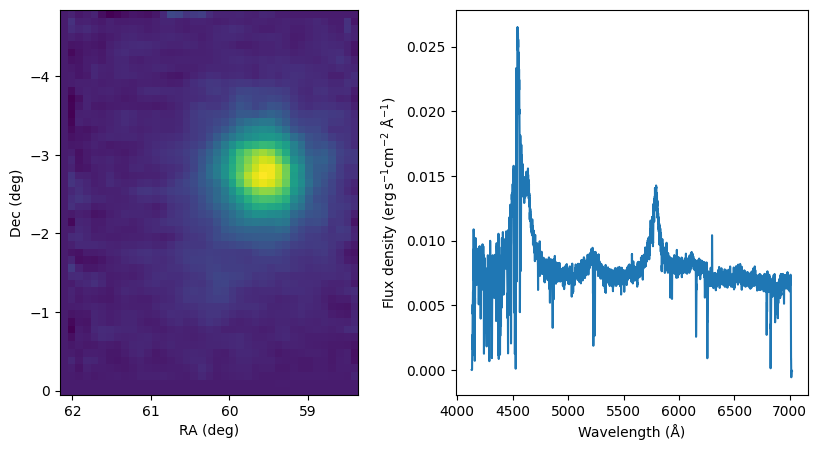

In [15]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1,2, figsize=(10,5))

##The extent command changes the axis value markers, by setting
##the first and last value of each axis like
##extent=[x_first, x_last, y_first, y_last]
##We can use the first and last values of both our ras, decs
##arrays from Ex 6.1 to set these values
##Remember that imshow plots array[0,0] top left, include
##the origin='lower' command to combine with extent correctly
axs[0].imshow(data[904,:,:],extent=[ras[0], ras[-1], decs[0], decs[-1]],origin='lower')

##This is how I figure out what pixels to plot - gives
##the location of the brightest pixel in x,y coords
print(np.where(data[904,:,:] == np.max(data[904,:,:])))

axs[1].plot(wavelengths, data[:,28,26])

##labels labels labels
axs[0].set_xlabel('RA (deg)')
axs[0].set_ylabel('Dec (deg)')

axs[1].set_xlabel("Wavelength (Å)")
axs[1].set_ylabel("Flux density ($\mathrm{erg}\,\mathrm{s}^{-1} \mathrm{cm}^{-2}$ Å$^{-1}$)")

plt.show()

## 3D plotting
Right, quick tangent here. You can plot things in 3D using matplotlib. Here, I'm going to use a helper function from `astropy` to plot an Airy disk in 3D. Once you run this code, the 3D plot that appears is interactive. Try clicking and dragging to rotate the output! Once you're done, click the button in top right to switch the plot off; will save you some processing power.

<IPython.core.display.Javascript object>


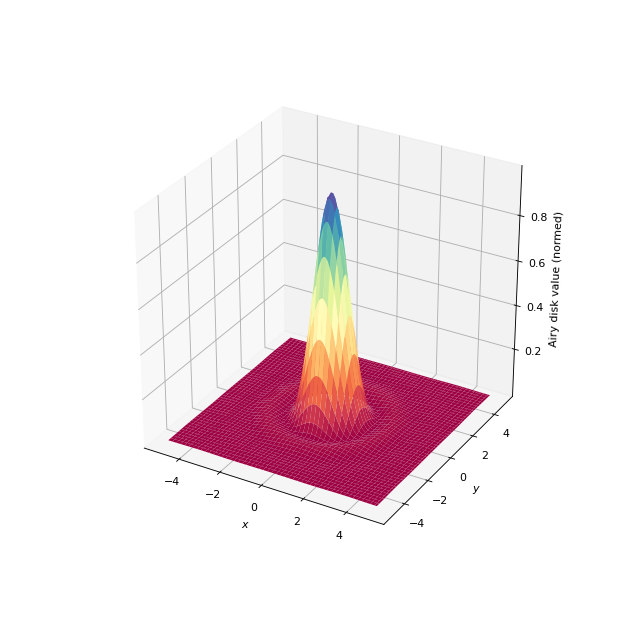

In [18]:
##Sometimes switching from inline to notebook causes weirdness
##to happen. For some reason you can fix that by calling
##notebook twice. Beats me as to why. We want notebook mode
##so we can interact with our 3D plot

import matplotlib.pyplot as plt
%matplotlib notebook
%matplotlib notebook

##Need this for 3D plotting
from mpl_toolkits.mplot3d import Axes3D

##This is a helper function to get an AiryDisk in 2D
from astropy.modeling.functional_models import AiryDisk2D

##Setup some coords and variables
coord_range = np.linspace(-5,5,100)
##You need 2D arrays as coordinates to plot a 3D plot
x_mesh, y_mesh = np.meshgrid(coord_range, coord_range)

amplitude = 1
##Central coords of the Airy Disk
x0, y0 = 0, 0
radius = 2

##This function has returned a 2D array of airy disk valuyes
airy_values = AiryDisk2D.evaluate(x_mesh, y_mesh, amplitude, x0, y0, radius)

##Create a figure
fig = plt.figure(figsize=(8,8))
##Add a single axes, with a 3D projection
ax = fig.add_subplot(111, projection='3d')

##This creates a surface plot at all x, y values, for the
##given z values of airy_values
##The dimensions of x, y, z must all be the same and 2D
ax.plot_surface(x_mesh, y_mesh, airy_values, cmap='Spectral')

##LABELS
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
##Ooooh zlabel
ax.set_zlabel('Airy disk value (normed)')

plt.show()

Can you guess why I've shown you how to do this? Correct! You are now going to plot some of the AGN data in 3D.

## <font color='blue'> Ex 6.3 </font>
Make 3D plot of a slice of the data, where the x axis is RA, y axis is Wavelength, and z axis is Flux density. For the flux density to plot, use slice I have given below. Your plot should end up looking something like the below. Funky!

<img src="3D_spectra.png" width="600">

<IPython.core.display.Javascript object>


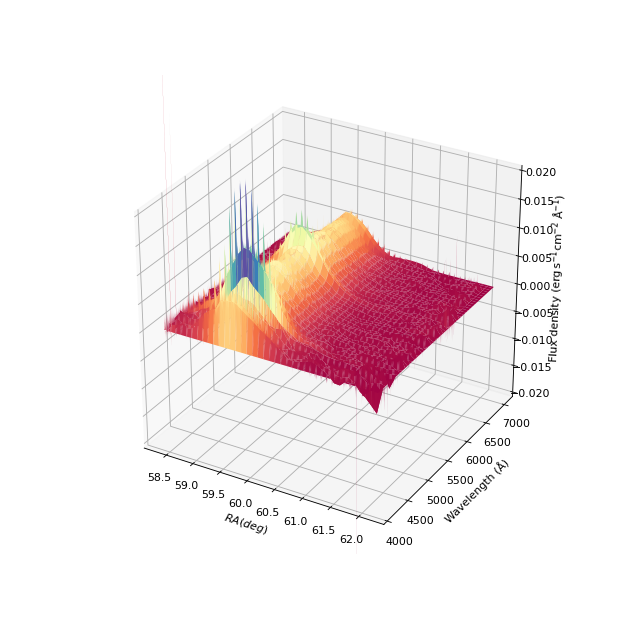

(-0.02, 0.02)

In [19]:
%matplotlib notebook
%matplotlib notebook

##Need 2D coordinates for a 3D plot, so meshgrid
##the ras and wavelengths together
ra_mesh, wave_mesh = np.meshgrid(ras, wavelengths)

##Data for the 2D surface
plot_slice = data[:,28,:]

##Check all arrays have the same shape
# print(ra_mesh.shape,wave_mesh.shape,plot_slice.shape)

##Create a figure
fig = plt.figure(figsize=(8,8))
##Add a single axes, with a 3D projection
ax = fig.add_subplot(111, projection='3d')

##This creates a surface plot at all x, y values, for the
##given z values of the airy_values
ax.plot_surface(ra_mesh, wave_mesh, plot_slice,cmap='Spectral')
# ax.contour(ra_mesh, wave_mesh, plot_slice)

##LABELS
ax.set_xlabel('$RA (deg)$')
ax.set_ylabel("Wavelength (Å)")

##Ooooh zlabel
ax.set_zlabel("Flux density ($\mathrm{erg}\,\mathrm{s}^{-1} \mathrm{cm}^{-2}$ Å$^{-1}$)")
ax.set_zlim(-0.02, 0.02)

# plt.show()

Ok, so the mountain-range like plot we get shows that the AGN emits at all of the wavelengths in our observations, but there are a few prominent peaks - these bumps are caused by different physical processes, so fitting and understanding them can tell us about the AGN.

## Preparing the data
Real data is always messy. Instrumental and atmospheric effects always creep in, and this data is no exception. I'm not an optical expert, so I don't understand the nitty-gritty of what's happening here, especially as the instrument does fancy things to split the observation into frequency bins using a spectrometer. Sometimes it's practical to _smooth_ the data, so we'll do that here to learn how. What does smoothing mean?

### Smoothing data
If your data are noisy, fitting models can be tricky. You can try and reduce the effect of noise by smoothing your data. Any smoothing function should attempt to mitigate the effects of noise, while retaining the underlying true distribution of the data. We've smoothed data once before, when we used a Kernel Density Estimator (KDE) as an alternative to a histogram.

We're going to need to smooth this AGN data for fitting, and this time we're going to us a Savitzky–Golay (SavGol) filter (see [here](https://en.wikipedia.org/wiki/Savitzky%E2%80%93Golay_filter) for an overview). In short the SavGol filter splits the data up into multiple chunks, and fits each chunk with a polynomial. Luckily for us, there is an existing implementation in `scipy`. Let's see what it does on some example data:

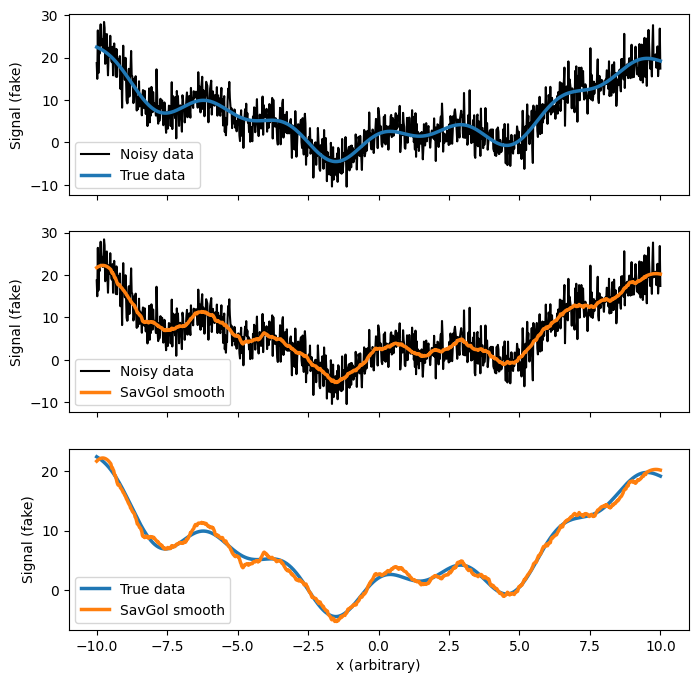

In [16]:
%matplotlib inline
from scipy.signal import savgol_filter
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(92834)

##Apparently I love making random data

##Make some fake data
num_samples = 1000
x_range = np.linspace(-10,10,num_samples)
fake_data =  3.0*np.sin(x_range) + 0.2*x_range**2 + 2.0*np.cos(2*x_range)

##MAKE SOME NOISE
noise = np.random.normal(0.0,3.0,num_samples)
#print(noise)

##Documention for savgol_filter shows:
##scipy.signal.savgol_filter(x, window_length, polyorder, ...)

##window_length is how many data go into each polynomial fit
##polyorder is the order of the polynomail you fit

window_length = 51
polyorder = 2
smoothed = savgol_filter(fake_data+noise,window_length, polyorder)

##Plot em up
##the sharex keyword means that subplots share the x-axis
##if you modify one x-axis, they all change
fig, axs = plt.subplots(3,1,sharex=True, figsize=(8,8))

axs[0].plot(x_range, fake_data+noise, 'k', label='Noisy data')
axs[0].plot(x_range, fake_data, 'C0', label='True data',lw=2.5)

axs[1].plot(x_range, fake_data+noise, 'k', label='Noisy data')
axs[1].plot(x_range, smoothed, 'C1', label='SavGol smooth',lw=2.5)

axs[2].plot(x_range, fake_data, 'C0', label='True data',lw=2.5)
axs[2].plot(x_range, smoothed, 'C1', label='SavGol smooth',lw=2.5)

for ax in axs:
    ax.legend()
    ax.set_ylabel('Signal (fake)')
    
axs[2].set_xlabel('x (arbitrary)')

plt.show()


You can see that the SavGol does a good, but not perfect, job at reconstructing the original data. The dark art is in choosing `window_length` and `polyorder`. Try changing them and seeing what it does to your smooth result (note `window_length` must be odd). What numbers are sensible to choose will all depend on your data and/or analysis.

## <font color='Blue'> Ex 6.4 </font>
Smooth the data in this slice `data[:,28,26]` using a SavGol filter. Plot your smoothed results over the original noisy data in two plots: one where you plot the full range of wavelengths, and another where you used `set_xlim` to zoom in and see the finer details of your smoothed result. Remember that the x-axis here will be wavelength, so plot against wavelength (and label your axes).

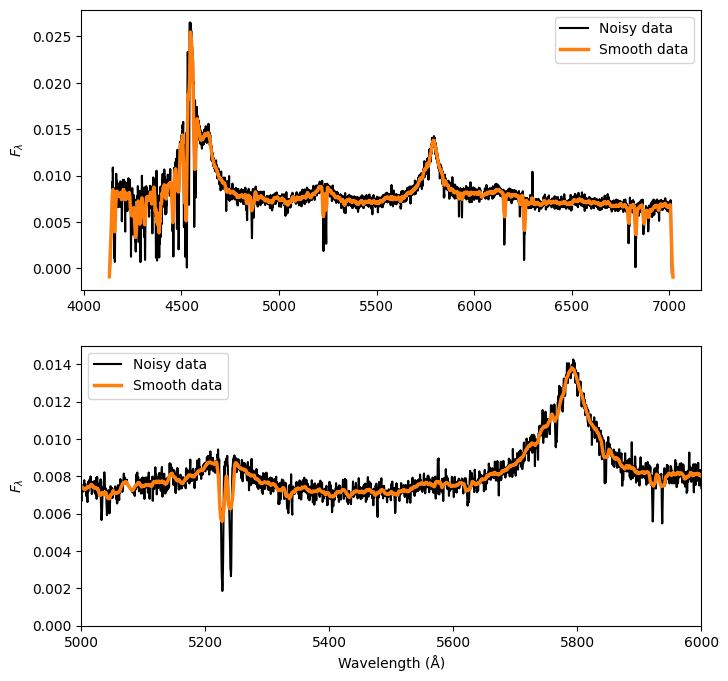

In [17]:
##Do pretty much as explained above!

window_length = 21
polyorder = 1
data_slice = data[:,28,26]
smoothed = savgol_filter(data_slice,window_length, polyorder)

##Plot em up
fig, axs = plt.subplots(2,1,figsize=(8,8))

axs[0].plot(wavelengths, data_slice, 'k', label='Noisy data')
axs[0].plot(wavelengths, smoothed, 'C1', label='Smooth data',lw=2.5)

axs[1].plot(wavelengths, data_slice, 'k', label='Noisy data')
axs[1].plot(wavelengths, smoothed, 'C1', label='Smooth data',lw=2.5)

##Set some limits to see finer detail in result
##You could also use %matplotlib notebook and zoom in
axs[1].set_xlim(5000,6000)
axs[1].set_ylim(0.0,0.015)

for ax in axs:
    ax.legend()
    ax.set_ylabel('$F_{\lambda}$')
    
axs[1].set_xlabel('Wavelength (Å)')

plt.show()

## Known emission lines
Right, as different elements have different atomic structures, with electrons occupying specific energy levels, they are able to emit and absorb specific wavelength photons. If we can detect these wavelengths, we can infer the presence of that specific chemical. In the table below, there are a few example of transitions:

| Emitter | Wavelength (Å) |
| --- | --- |
| Lyman $\alpha$ | 1216 |
| N V            | 1240 |
| Silicon IV     | 1397 |
| Carbon IV      | 1549 |
| He II          | 1640 |

Now, this AGN isn't next door, in fact it's in a galaxy far, far away. This means any radiation we recieve has been redshifted. We can adjust the wavelengths of our observation to account for this, using the redshift, $z$. For this AGN, $z = 2.73763$, which was likely found by matching narrow-line emission from the AGN to known emission spacing for a number of elements, to deduce the amount of redshifting (Clare is on holiday, which she deserves, so I'll leave her alone and ask her when she comes back). We undo the redshift-effect like this:

In [18]:
z = 2.73763
rest_wavelengths = wavelengths / (z+1)

## <font color='Blue'> Ex 6.5 </font>
Plot your smoothed data from Ex 6.4 against the `rest_wavelengths` array. Then plot a vertical line (I suggest using `ax.axvline` as we have done before) of the three emission lines listed above on your plot, to see if you have emission at those wavelengths. Use a different colour for each line, and add a legend naming the three lines. Your plot should look something like this:

![emission_lines.png](emission_lines.png)

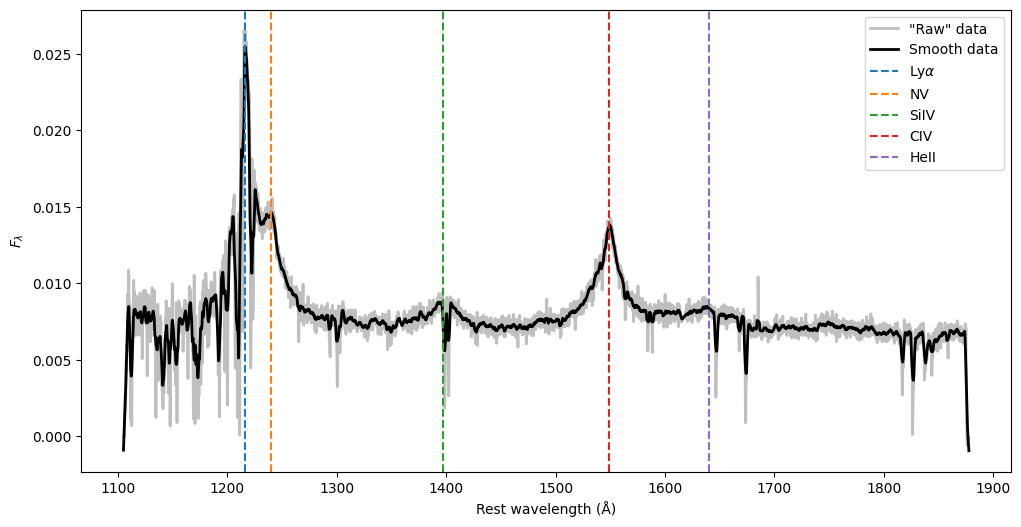

In [19]:
fig, ax = plt.subplots(1,1,figsize=(12,6))

z = 2.73763

ax.plot(rest_wavelengths, data[:,28,26], 'gray', label='"Raw" data',lw=2.0, alpha=0.5)
ax.plot(rest_wavelengths, smoothed, 'k', label='Smooth data',lw=2.0)

##Wavelengths
lines = [1216, 1240, 1397, 1549, 1640]
##Labels
labels = [r'Ly$\alpha$', 'NV', 'SiIV', 'CIV', 'HeII']

##Setup a colour index so I can iterate over colours
colour=0
##Iterate over line and label
for line,label in zip(lines,labels):
    ##Change the colour, where C0, C1, C2 are the three first
    ##default colours in matplotlib
    ax.axvline(line,color="C{:d}".format(colour),linestyle='--',label=label)
    ##Add one to the colour for the next iteration
    colour += 1

##Add the legend
ax.legend()

##LAAAAAAAAAAAAAABEEEEEEEEEELLLLLSSS
ax.set_xlabel('Rest wavelength (Å)')
ax.set_ylabel('$F_\lambda$')

plt.show()
# fig.savefig('emission_lines.png',bbox_inches='tight')


## Fitting an emission line
It's time for you to dust off your `lmfit` knowledge, as we're going to do some fitting. Believe it or not, I taught you `lmfit` with this fitting problem in mind. That's right! I slightly planned the curriculum!

We're going to focus in on the CIV line, as it has a well-defined peak for us to fit. As you'll know because you've watched Clare's lecture and you are a good KAS2020 participant, there are two components to the emission:

 1. Contiuum emission (that comes off the accretion disk) which usually follows a power-law
 2. Emission from the element under investigation

To accurately measure the flux of the line emission, we have to fit both the continuum, and the broadline emission. We can do that simultaneously using `lmfit`. I'm going to try fitting the emission with a Gaussian in this example:

[[Model]]
    (Model(gaussian, prefix='gauss_') + Model(powerlaw, prefix='power_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 315
    # data points      = 4675
    # variables        = 5
    chi-square         = 0.00385145
    reduced chi-square = 8.2472e-07
    Akaike info crit   = -65483.4335
    Bayesian info crit = -65451.1835
[[Variables]]
    gauss_amplitude:  0.17514455 +/- 0.00292005 (1.67%) (init = 1)
    gauss_center:     1548.62286 +/- 0.24625571 (0.02%) (init = 1549)
    gauss_sigma:      13.6981652 +/- 0.25211637 (1.84%) (init = 1)
    power_amplitude:  0.14547012 +/- 0.01846709 (12.69%) (init = 1)
    power_exponent:  -0.40718042 +/- 0.01724891 (4.24%) (init = 1)
    gauss_fwhm:       32.2567133 +/- 0.59368868 (1.84%) == '2.3548200*gauss_sigma'
    gauss_height:     0.00510087 +/- 8.0016e-05 (1.57%) == '0.3989423*gauss_amplitude/max(2.220446049250313e-16, gauss_sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(power_am

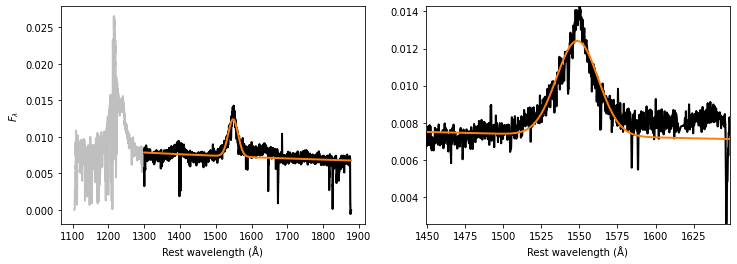

In [24]:
from lmfit.models import PowerLawModel, GaussianModel

##Let's use the same x,y of data and name it
spectra = data[:,28,26]

##Little function to trim the data
def spectra_subset(spectra, wavelengths, lower_wave, upper_wave):
    """Takes the given spectra and wavelengths (in
    angstrom) and crops the data and wavelength range
    to only include (angstrom)"""
    
    ##The where function returns an array of indexes where
    ##the boolean logic is true
    indexes = np.where((wavelengths >= lower_wave) & (wavelengths <= upper_wave))
    ##Use our result from where to crop the spectra and wavelengths
    return spectra[indexes], wavelengths[indexes]

##You can combine lmfit models just by adding them like this:
gauss_and_power_model = GaussianModel(prefix='gauss_') + PowerLawModel(prefix='power_')

##You create the params in the same way as you would a single model
gauss_and_power_params = gauss_and_power_model.make_params()

CIV_line = 1549
##Start the fitting at the line centre that we want
gauss_and_power_params['gauss_center'].set(value=CIV_line)


##Trim the data to not include to big ol' Lyman alpha peak
trim_spectra, trim_wavelengths = spectra_subset(spectra, rest_wavelengths, 1300, 1900)

##Do the fit
fit = gauss_and_power_model.fit(trim_spectra, gauss_and_power_params, x=trim_wavelengths)

##prints a report on the outcome of the fitting
print(fit.fit_report())

##This returns the fitted model for plotting
fit_values = fit.best_fit


##Do some plotting
fig, axs = plt.subplots(1,2,figsize=(12,4))


for ax in axs:
    ##Plot all of the data to see the full range
    ax.plot(rest_wavelengths, spectra, 'gray', label='"Raw" data',lw=2.0, alpha=0.5)
    ax.plot(trim_wavelengths, trim_spectra, 'k', label='Smooth data',lw=2.0)
    ax.plot(trim_wavelengths,fit.best_fit,color='C1',lw=2.0)
    ax.set_xlabel('Rest wavelength (Å)')

axs[0].set_ylabel('$F_\lambda$')
    

xlim_low, xlim_up = CIV_line-100,CIV_line+100
subset = trim_spectra[(trim_wavelengths >= xlim_low) & (trim_wavelengths <= xlim_up)]

axs[1].set_xlim(xlim_low, xlim_up)
axs[1].set_ylim(subset.min(),subset.max())

plt.show()




Right. Looking at the righthand plot here shows that the continuum fit isn't great directly around our CIV emission peak, especially on the right hand side. The tricky part is that there are multiple emission lines, and infact there is a HeII line sat at 1640Å which could be bumpig the righthand side up.

## <font color='Blue'> Ex 6.6 </font>
Try using some different models to fit the emission line by adapting the code above. The `lmfit` package has loads - try `VoigtModel`, `SkewedGaussianModel`, and `SkewedVoigtModel`. Each time you change the model, note if the fit improves, and how the fitted power law parameters also change. As well as changing the model, try changing the range of wavelengths you fit over, and see what effect that has. These are all things we have to try (and justify) when doing astronomy.

In the next notebook, we're going to look into how you would pull all the functionality we have covered here into a stand-alone script, with command-line input arguments.

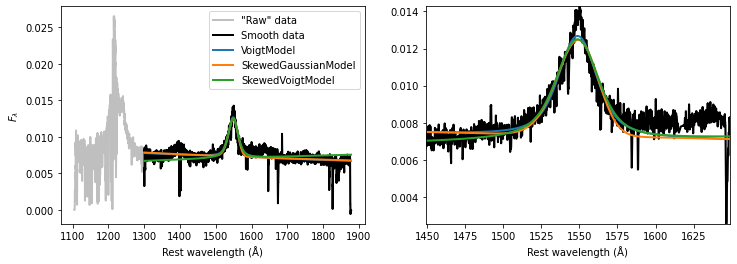

In [27]:
from lmfit.models import VoigtModel, SkewedGaussianModel, SkewedVoigtModel

CIV_line = 1549
trim_spectra, trim_wavelengths = spectra_subset(spectra, rest_wavelengths, 1300, 1900)

def do_and_plot_fit(lm_model, trim_spectra, trim_wavelengths, axs, label):
    """Takes an lmfit.models instance (lm_model) and fits a spectra
    as described by trim_spectra, trim_wavelenghts. Plots the fits and
    data on the give axs, and labels using label"""

    ##You can combine lmfit models just by adding them like this:
    gauss_and_power_model = lm_model(prefix='emission_') + PowerLawModel(prefix='power_')

    ##You create the params in the same way as you would a single model
    gauss_and_power_params = gauss_and_power_model.make_params()

    ##Start the fitting at the line centre that we want
    gauss_and_power_params['emission_center'].set(value=CIV_line)
    
    ##Do the fit
    fit = gauss_and_power_model.fit(trim_spectra, gauss_and_power_params, x=trim_wavelengths)

    ##prints a report on the outcome of the fitting
#     print(fit.fit_report())

    ##This returns the fitted model for plotting
    fit_values = fit.best_fit
    
    axs[0].plot(trim_wavelengths,fit.best_fit,lw=2.0, label=label)
    axs[1].plot(trim_wavelengths,fit.best_fit,lw=2.0, label=label)
    
    return fit


##Do some plotting
fig, axs = plt.subplots(1,2,figsize=(12,4))

##Plotting and labelling
for ax in axs:
    ##Plot all of the data to see the full range
    ax.plot(rest_wavelengths, spectra, 'gray', label='"Raw" data',lw=2.0, alpha=0.5)
    ax.plot(trim_wavelengths, trim_spectra, 'k', label='Smooth data',lw=2.0)
    ax.set_xlabel('Rest wavelength (Å)')

axs[0].set_ylabel('$F_\lambda$')


##Use the function as defined above to plot multiple models
do_and_plot_fit(VoigtModel, trim_spectra, trim_wavelengths, axs, 'VoigtModel')
do_and_plot_fit(SkewedGaussianModel, trim_spectra, trim_wavelengths, axs, 'SkewedGaussianModel')
do_and_plot_fit(SkewedVoigtModel, trim_spectra, trim_wavelengths, axs, 'SkewedVoigtModel')
    
##Tidy up limits
xlim_low, xlim_up = CIV_line-100,CIV_line+100
subset = trim_spectra[(trim_wavelengths >= xlim_low) & (trim_wavelengths <= xlim_up)]

axs[1].set_xlim(xlim_low, xlim_up)
axs[1].set_ylim(subset.min(),subset.max())

axs[0].legend()

plt.show()